# pyltspice

This is something I put together to automate and analyze my LTspice simulations in Python.

There are some existing libraries out there for this, such as [this](https://pypi.org/project/PyLTSpice/) more fully-featured project of the same name, but at the time I couldn't find one that worked for me.

This project takes a lightweight, functional approach. It is structured as a single module (.py file) that contains 
a set of functions that output SPICE code, operate on netlists, dispatch LTspice, and parse the various output files.

## Installation

This package is not registered on PyPI.  To install,

1. Clone/download this repo
3. Run `pip install .` inside the pyltspice directory.

You will also need to install LTspice (XVII or later).

## How to use

In [1]:
import pyltspice
from pyltspice import *

Simulation files will be stored at C:\Users\t\ltspice_sims.  To change, overwrite the simfolder variable


Here's how you can change the output directory:

In [2]:
pyltspice.simfolder = r'C:\Users\t\ltspice_sims'

We represent netlists in python as a list of strings.  You may write them directly in python or read them from a file using the function `netlist_fromfile()`.

I drew this very interesting example circuit in the LTspice GUI: 


<img src="images/LCR.png" width=300>

We work with SPICE netlists, not the PCB manufacturing formats now in the export options of recent LTspice versions.  For those, you can get a SPICE netlist from the GUI using `View → Spice NETLIST`, then copy-paste the text.

The netlist for the circuit above is included in this repository, and its path is stored in the variable `netlist_path`

In [3]:
netlist = netlist_fromfile(netlist_path)
netlist

['* Example netlist',
 'V1 in 0 PULSE(0 5 1m 1n 1n 10m)',
 'R1 in N001 {R}',
 'L1 N001 N002 {L}',
 'C1 N002 0 {C}',
 '.PARAM C=1e-6',
 '.PARAM L=1e-3',
 '.PARAM R=1',
 '.tran 0 10m 0',
 '.backanno',
 '.end']

These netlists can be passed to the function `runspice()`, which writes the netlist to a file, executes it with LTspice,
reads the output binary file and returns the simulation results as a dictionary.


In [4]:
data = runspice(netlist)

Writing C:\Users\t\ltspice_sims\2024-09-03_161937_288_Example_netlist.net
Executing C:\Users\t\ltspice_sims\2024-09-03_161937_288_Example_netlist.net
Reading C:\Users\t\ltspice_sims\2024-09-03_161937_288_Example_netlist.raw
Reading C:\Users\t\ltspice_sims\2024-09-03_161937_288_Example_netlist.log
Reading C:\Users\t\ltspice_sims\2024-09-03_161937_288_Example_netlist.net


The returned data combines information from the output .log file and the binary (.raw) file, and also includes the netlist and other metadata.

Here's what it looks like:

In [5]:
# pandas used here just for prettier printing
import pandas as pd
pd.Series(data)

filepath          C:\Users\t\ltspice_sims\2024-09-03_161937_288_...
Title                                             * Example netlist
Date                                       Tue Sep  3 16:19:37 2024
Plotname                                         Transient Analysis
Flags                                                  real forward
No. Variables                                                     8
No. Points                                                      932
Offset                                       0.0000000000000000e+00
Command                       Linear Technology Corporation LTspice
time              [0.0, 0.001, 0.0010000001606947238, 0.00100000...
V(in)             [0.0, 0.0, 0.8034736, 1.6069472, 3.1470428, 5....
V(n001)           [0.0, 0.0, 0.80347353, 1.606947, 3.1470416, 4....
V(n002)           [0.0, 0.0, 8.4442574e-12, 5.3361017e-11, 3.171...
I(C1)             [0.0, 0.0, 7.907755e-08, 3.191806e-07, 1.13626...
I(L1)             [0.0, 0.0, 7.907755e-08, 3.191

Note that there is some overhead to do the simulation including the file IO:

In [6]:
dt = data['sim_time_total'] - data['sim_time']
print(f'Extra time needed: {dt:.3f} s')

Extra time needed: 0.407 s


Repeated runs of the same netlist will use the already existing result, which will be faster.

In [7]:
data = runspice(netlist)

Reading the previous result of a matching simulation from disk
Reading C:\Users\t\ltspice_sims\2024-09-03_161937_288_Example_netlist.raw
Reading C:\Users\t\ltspice_sims\2024-09-03_161937_288_Example_netlist.log
Reading C:\Users\t\ltspice_sims\2024-09-03_161937_288_Example_netlist.net


Plot the results

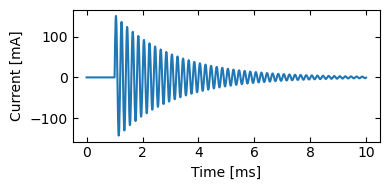

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
t = data['time']
I = data['I(R1)']
plt.figure(figsize=(4,2))
plt.plot(t * 1e3, I * 1e3)
plt.xlabel('Time [ms]')
plt.ylabel('Current [mA]');

If you are annoyed by the print statements, you can deactivate them like this:

In [9]:
pyltspice.verbose = False

From here, you *could* just modify the netlists directly through list and string operations.

But we also have a set of python functions that evaluate to spice code (strings).  These should be a little more convenient than writing the spice directly.  Only some of the common spice commands are implemented currently, but you are welcome to extend it.

For example:

In [10]:
resistor(num=1, cathode=0, anode='N001', val=300)

'R1 0 N001 300'

In [11]:
sine(freq=1e3, amp=2, delay=1e-3)

'SINE(0 2 1000.0 0.001 0 0 )'

There are also functions for inserting new commands into existing netlists.

The main function to use is `netchange()`, which takes a netlist as the first argument and incorporates more lines passed as additional arguments. For each input line, it decides whether to add a new line to the netlist or to overwrite an existing line.  You can pass it individual lines as strings,  partial netlists as lists of strings, or both.

Input netlists are never modified.  Rather, new netlists are always returned by the functions.

For example, to change a parameter,

In [18]:
netchange(netlist, R=3.3)

['* Example netlist',
 'V1 in 0 PULSE(0 5 1m 1n 1n 10m)',
 'R1 in N001 {R}',
 'L1 N001 N002 {L}',
 'C1 N002 0 {C}',
 '.PARAM C=1e-6',
 '.PARAM L=1e-3',
 '.PARAM R=3.3',
 '.tran 0 10m 0',
 '.backanno',
 '.end']

to add a circuit element,

In [21]:
netchange(netlist, resistor(2, 'in', 0, 50))

['* Example netlist',
 'V1 in 0 PULSE(0 5 1m 1n 1n 10m)',
 'R1 in N001 {R}',
 'R2 in 0 50',
 'L1 N001 N002 {L}',
 'C1 N002 0 {C}',
 '.PARAM C=1e-6',
 '.PARAM L=1e-3',
 '.PARAM R=1',
 '.tran 0 10m 0',
 '.backanno',
 '.end']

You can add as many lines as you want:

* test
V1 in 0 PULSE(0 5 1m 1n 1n 10m)
V2 N002 N003 PULSE(0 4 0.002 1e-09 1e-09 0.001 0.003000002 )
R1 in N001 {R}
L1 N001 N002 {L}
C1 N003 0 {C}
.PARAM C=2e-06
.PARAM L=0.002
.PARAM R=1
.tran 0 0.005 0 0.0001
.backanno
.end


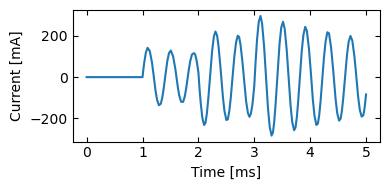

In [46]:
newnet = netchange(netlist,
                      '* test',
                      capacitor(1, 'N003', 0, '{C}'),
                      voltage_source(2, 'N002', 'N003', pulse(0, 4, 1e-9, 1e-3, 1e-9, delay=2e-3)),
                      transient(0, 5e-3),
                      L=2e-3,
                      C=2e-6
                      )

print('\n'.join(newnet))
newdata = runspice(newnet)

t = newdata['time']
I = newdata['I(R1)']
plt.figure(figsize=(4,2))
plt.plot(t * 1e3, I * 1e3)
plt.xlabel('Time [ms]')
plt.ylabel('Current [mA]');

Now we can automate our simulation runs and get back a useful data structure for further analysis.  

For example, here we vary all the parameters by ±50%:

In [14]:
datalist = []
for name, value in get_params(netlist).items():
    for v in np.linspace(0.5 * value, 1.5 * value, 5):
        data = runspice(netchange(netlist, param(name, v)));
        datalist.append(data)

In [15]:
pd.DataFrame(datalist)[['R', 'L', 'C', 'sim_time', 'time', 'I(R1)']]

,R,L,C,sim_time,time,I(R1)
0,1.00,0.00100,5.000000e-07,0.008,"[0.0, 0.001, 0.0010000001606947238, 0.00100000...","[0.0, 0.0, 7.907755e-08, 3.191806e-07, 1.13626..."
1,1.00,0.00100,7.500000e-07,0.008,"[0.0, 0.001, 0.0010000001606947238, 0.00100000...","[0.0, 0.0, 7.907755e-08, 3.191806e-07, 1.13626..."
2,1.00,0.00100,1.000000e-06,0.014,"[0.0, 0.001, 0.0010000001606947238, 0.00100000...","[0.0, 0.0, 7.907755e-08, 3.191806e-07, 1.13626..."
3,1.00,0.00100,1.250000e-06,0.009,"[0.0, 0.001, 0.0010000001606947238, 0.00100000...","[0.0, 0.0, 7.907755e-08, 3.191806e-07, 1.13626..."
4,1.00,0.00100,1.500000e-06,0.009,"[0.0, 0.001, 0.0010000001606947238, 0.00100000...","[0.0, 0.0, 7.907755e-08, 3.191806e-07, 1.13626..."
5,1.00,0.00050,1.000000e-06,0.009,"[0.0, 0.001, 0.0010000000229959374, 0.00100000...","[0.0, 0.0, 3.2065541e-09, 6.207098e-09, 1.5922..."
6,1.00,0.00075,1.000000e-06,0.009,"[0.0, 0.001, 0.001000000160694725, 0.001000000...","[0.0, 0.0, 1.0543673e-07, 4.255741e-07, 1.5150..."
7,1.00,0.00100,1.000000e-06,0.008,"[0.0, 0.001, 0.0010000001606947238, 0.00100000...","[0.0, 0.0, 7.907755e-08, 3.1918057e-07, 1.1362..."
8,1.00,0.00125,1.000000e-06,0.007,"[0.0, 0.001, 0.001000000160694725, 0.001000000...","[0.0, 0.0, 6.326204e-08, 2.5534447e-07, 9.0901..."
9,1.00,0.00150,1.000000e-06,0.008,"[0.0, 0.001, 0.0010000001606947245, 0.00100000...","[0.0, 0.0, 5.2718367e-08, 2.1278707e-07, 7.575..."


(0.9, 5.0)

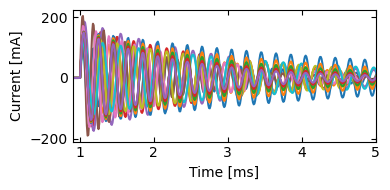

In [20]:
plt.figure(figsize=(4,2))
plt.xlabel('Time [ms]')
plt.ylabel('Current [mA]');
for data in datalist:
    plt.plot(data['time'] * 1e3, data['I(R1)'] * 1e3)
plt.xlim(0.9, 5)

### Notes

I would not call this production-ready.  If in doubt, use [PyLTSpice](https://pypi.org/project/PyLTSpice/).

We have had some success using multiprocessing to increase the speed when running many simulations, but that code is not included yet.

Error handling is not very sophisticated.  If you write an error in your netlist, sometimes python just hangs while it waits for LTspice to respond.  In this case, use task manager to end the SPICE Simulator.